# ML in Cybersecurity: Project II

## Team
  * **Team name**:  *Mittwoch*
  * **Members**:  Philipp Zimmermann (s8phzimm@stud.uni-saarland.de), Vilém Zouhar (vilem.zouhar@gmail.com) and Alina Leippert - left (alle00002@stud.uni-saarland.de)
  * **Tutor**: *fill this in*


## Logistics
  * **Due date**: 14th December 2020, 13:59:59 
  * Email the completed notebook to mlcysec_ws2021_staff@lists.cispa.saarland 
  * Complete this in the previously established **teams of 3**
  * Feel free to use the course [mailing list](https://lists.cispa.saarland/listinfo/mlcysec_ws2021_stud) to discuss.
  
## Timeline
  * 30-Nov-2020: Project 2 hand-out
  * **14-Dec-2020** (13:59:59): Email completed notebook to mlcysec_ws2021_staff@lists.cispa.saarland

  
  
## About this Project
In this project, we dive into the vulnerabilities of machine learning models and the difficulties of defending against them. To this end, we require you to implement an evasion attack (craft adversarial examples) yourselves, and defend your own model.   


## A Note on Grading
The total number of points in this project is 100. We further provide the number of points achievable with each excercise. You should take particular care to document and visualize your results, though.


 
## Filling-in the Notebook
You'll be submitting this very notebook that is filled-in with (all!) your code and analysis. Make sure you submit one that has been previously executed in-order. (So that results/graphs are already visible upon opening it). 

The notebook you submit **should compile** (or should be self-contained and sufficiently commented). Check tutorial 1 on how to set up the Python3 environment.

It is extremely important that you **do not** re-order the existing sections. Apart from that, the code blocks that you need to fill-in are given by:
```
#
#
# ------- Your Code -------
#
#
```
Feel free to break this into multiple-cells. It's even better if you interleave explanations and code-blocks so that the entire notebook forms a readable "story".


## Code of Honor
We encourage discussing ideas and concepts with other students to help you learn and better understand the course content. However, the work you submit and present **must be original** and demonstrate your effort in solving the presented problems. **We will not tolerate** blatantly using existing solutions (such as from the internet), improper collaboration (e.g., sharing code or experimental data between groups) and plagiarism. If the honor code is not met, no points will be awarded.

 
 ## Versions
  * v1.0: Initial notebook
  * v1.1: Clarifications at 1.1.2, 1.2.2, 2.1
 
  ---

In [7]:
import time 
 
import numpy as np 
import matplotlib.pyplot as plt 

import json 
import time 
import pickle 
import sys 
import csv 
import os 
import os.path as osp 
import shutil 

import pandas as pd

from IPython.display import display, HTML
 
%matplotlib inline 
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots 
plt.rcParams['image.interpolation'] = 'nearest' 
plt.rcParams['image.cmap'] = 'gray' 
 
# for auto-reloading external modules 
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython 
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
# Some suggestions of our libraries that might be helpful for this project
from collections import Counter          # an even easier way to count
from multiprocessing import Pool         # for multiprocessing
from tqdm import tqdm                    # fancy progress bars

# Load other libraries here.
# Keep it minimal! We should be easily able to reproduce your code.
# We only support sklearn and pytorch.
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch.utils.data as data

# We preload pytorch as an example
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, TensorDataset

import torchvision
import random
import PIL

%pip install foolbox

In [9]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Running on', DEVICE)

if str(DEVICE) == 'cpu':
    device = torch.device('cpu')
elif str(DEVICE) in {'gpu', 'cuda'}:
    # If you are using pytorch on the GPU cluster, you have to manually specify which GPU device to use
    # It is extremely important that you *do not* spawn multi-GPU jobs.
    os.environ["CUDA_VISIBLE_DEVICES"] = '0'    # Set device ID here
else:
    raise ValueError('Unrecognized compute mode')

Running on cuda


#### Helpers

In case you choose to have some methods you plan to reuse during the notebook, define them here. This will avoid clutter and keep rest of the notebook succinct.

In [10]:
def identity_func(foo):
    return foo

def evaluate(data_loader, loss_fn, DEVICE, model, compute_only=False):
  false_classification = []
  test_loss = 0.0
  test_acc = 0
  for inputs, labels in data_loader:
      inputs = inputs.to(DEVICE)
      labels = labels.to(DEVICE)

      # forward
      out = model(inputs)
      out = out.view(-1, 10)
      t_loss = loss_fn(out, labels)
      test_loss += t_loss.item()*inputs.size(0)
          
      # calculate predictions & accuracy
      _, pred = torch.max(out, 1)
      test_acc += torch.sum(pred == labels)

      preds = (pred == labels)
      for x in range(len(preds)):
          if not preds[x]:
              img = inputs[x].view(-1, 28).cpu().numpy()
              correct_label = labels[x]
              wrong_label = pred[x]
              false_classification.append((img, correct_label, wrong_label))

  # calculate data
  test_loss = test_loss/len(data_loader.dataset)
  test_acc = test_acc/len(data_loader.dataset)

  if not compute_only:
    # print(f'Loss:          {test_loss:.4f}')
    print(f'Acc: {test_acc:.4f} ({len(false_classification)}/{len(data_loader.dataset)} bad)')
  return test_acc

def single_predict(inputs, DEVICE, model):
    inputs = inputs.to(DEVICE)

    out = model(inputs)
    out = out.view(-1, 10)
        
    _, pred = torch.max(out, 1)
    return pred

# 1. Attacking an ML-model

In this section, we implement an attack ourselves. We then leverage the Foolbox library to craft adversarial examples. First, however, you need a model you can attack. Feel free to choose the DNN/ConvNN from project 1.

Hint: you might want to save the trained model to save time later.

### 1.1.1: Setting up the model (5 Points)

Re-use the model from project 1 here and train it until it achieves reasonable accuracy (>92%).

In [11]:
# Hyper parameters
torch.manual_seed(0)
BATCH_SIZE = 60
NUM_EPOCHS = 60
LEARNING_RATE = 0.0005

# Load dataset
torch.manual_seed(0)
transform_base = transforms.Compose([
  transforms.ToTensor(),
  transforms.Normalize((0.5,), (0.5,)),
])

# Data preparation
VALIDATION_FRAC = 0.01
data_train = list(torchvision.datasets.MNIST('.', train=True, download=True, transform=transform_base))
data_test  = list(torchvision.datasets.MNIST('.', train=False, download=True, transform=transform_base))
random.seed(0)
random.shuffle(data_train)
data_valid = data_train[:int(len(data_train)*VALIDATION_FRAC)]
data_train = data_train[int(len(data_train)*VALIDATION_FRAC):]
get_data_flat = lambda data: [(np.reshape(img, (28, 28)).type(torch.FloatTensor).view(1, 784), label) for (img, label) in data]
data_train_loader = torch.utils.data.DataLoader(get_data_flat(data_train), batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
data_eval_loader  = torch.utils.data.DataLoader(get_data_flat(data_valid), batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
data_test_loader = torch.utils.data.DataLoader(get_data_flat(data_test), shuffle=False, num_workers=0)

# Define the model
class M2(nn.Module):
  def __init__(self):
    super(M2, self).__init__()
    self.model = nn.Sequential(
      nn.Linear(784, 512),
      nn.ReLU(),
      nn.Dropout(p=0.4),
      nn.Linear(512, 256),
      nn.ReLU(),
      nn.Dropout(p=0.3),
      nn.Linear(256, 128),
      nn.ReLU(),
      nn.Dropout(p=0.1),
      nn.Linear(128, 10)
    )

  def forward(self, x):
    return self.model(x)

# Load the model
model = M2().to(DEVICE)
loss_fn = nn.CrossEntropyLoss()


# Train model
def train(model, data_train_loader, data_eval_loader, total_epochs, save_path):
  os.system(f'mkdir -p {save_path}')
  max_acc = 0.0
  optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

  for epoch in range(total_epochs):
      train_loss = 0
      eval_loss = 0
      eval_acc = 0

      misses = 0
      
      # training
      model.train()
      for inputs, labels in data_train_loader:
          inputs = inputs.to(DEVICE)
          labels = labels.to(DEVICE)

          optimizer.zero_grad()
          
          # forward
          output = model(inputs)
          output = output.view(-1, 10)
          loss = loss_fn(output, labels)

          # backward + optimization
          loss.backward()
          optimizer.step()
          train_loss += loss.item()*inputs.size(0)

      # evaluating
      model.eval()

      print(f'Epoch {epoch:<3} ------')
      eval_acc = evaluate(data_eval_loader, loss_fn, DEVICE, model)
      print(f'Training Loss: {train_loss:.4f}')
      # save model if validation loss has decreased
      if eval_acc >= max_acc:
          print(f'Saving ({eval_acc:.6f} >= {max_acc:.6f})')
          torch.save(model.state_dict(), f'{save_path}/epoch_{epoch:03}.pt')
          max_acc = eval_acc

train(model, data_train_loader, data_eval_loader, NUM_EPOCHS, 'models_base')

Epoch 0   ------
Acc: 0.9317 (41/600 bad)
Training Loss: 28071.1530
Saving (0.931667 >= 0.000000)
Epoch 1   ------
Acc: 0.9383 (37/600 bad)
Training Loss: 14032.5912
Saving (0.938333 >= 0.931667)
Epoch 2   ------
Acc: 0.9500 (30/600 bad)
Training Loss: 11292.3266
Saving (0.950000 >= 0.938333)
Epoch 3   ------
Acc: 0.9533 (28/600 bad)
Training Loss: 10125.8743
Saving (0.953333 >= 0.950000)
Epoch 4   ------
Acc: 0.9617 (23/600 bad)
Training Loss: 9056.4803
Saving (0.961667 >= 0.953333)
Epoch 5   ------
Acc: 0.9667 (20/600 bad)
Training Loss: 8058.7385
Saving (0.966667 >= 0.961667)
Epoch 6   ------
Acc: 0.9583 (25/600 bad)
Training Loss: 7768.5228
Epoch 7   ------
Acc: 0.9650 (21/600 bad)
Training Loss: 7318.7481
Epoch 8   ------
Acc: 0.9617 (23/600 bad)
Training Loss: 6842.6458
Epoch 9   ------
Acc: 0.9617 (23/600 bad)
Training Loss: 6482.5168
Epoch 10  ------
Acc: 0.9683 (19/600 bad)
Training Loss: 6187.2660
Saving (0.968333 >= 0.966667)
Epoch 11  ------
Acc: 0.9683 (19/600 bad)
Trainin

In [12]:
# load the model which we use as a base
def base_model():
  model = M2()
  model.load_state_dict(torch.load("models_base/epoch_033.pt"))
  model.eval()
  model.to(DEVICE)
  return model

model = base_model()
print('\nBase model from epoch 33:')
evaluate(data_test_loader, loss_fn, DEVICE, model)


Base model from epoch 33:
Acc: 0.9836 (164/10000 bad)


tensor(0.9836, device='cuda:0')

### 1.1.2: Implementing an attack (15 Points)

We now want you to attack the model trained in the previous step. Please implement the FGSM attack mentioned in the lecture. 

In [13]:
# Parameters
eps = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5]

# Load base model
model = base_model()

# FGSM image manipulation
def fgsm(image, epsilon, data_grad):
    sign_data_grad = data_grad.sign()
    adv_img = image + epsilon*sign_data_grad
    return adv_img

def _attack(epsilon, input_img, label):
        
    # forward
    out = model(input_img)
    out = out.view(-1, 10)
    loss = loss_fn(out, label)
        
    # calculate predictions
    _, pred = torch.max(out, 1)

    # ignore if initial pred is wrong
    if pred != label:
       return None
        
    # clear gradients
    model.zero_grad()
        
    # backpropagation
    loss.backward()
        
    # collect gradient
    data_grad = input_img.grad.data
        
    # manipulate image (fgsm)
    adv_img = fgsm(input_img, epsilon, data_grad)
        
    # forward
    adv_out = model(adv_img)
    adv_out = adv_out.view(-1, 10)
        
    # calculate adversarial predictions
    _, adv_pred = torch.max(adv_out, 1)       

    return adv_img, adv_pred, pred


def attack(epsilon):
    adv_correct = 0

    for input_img, label in data_test_loader: 

        input_img = input_img.to(DEVICE)
        input_img.requires_grad = True
        label = torch.Tensor(np.array([label])).long().to(DEVICE)

        attack_res = _attack(epsilon, input_img, label)
        if attack_res is None:
          continue
        _, adv_pred, pred = attack_res
        
        if pred != label: continue

        # check classification
        if adv_pred == label:
            adv_correct += 1
    
    # output
    adv_acc = adv_correct/float(len(data_test_loader))
    print(f'Epsilon: {epsilon}, Adversarial Accuracy = {adv_correct} / {len(data_test_loader)} = {adv_acc:.3f}')
    return adv_acc

# Run test for each epsilon
for e in eps:
    acc = attack(e)

Epsilon: 0.0, Adversarial Accuracy = 9836 / 10000 = 0.984
Epsilon: 0.1, Adversarial Accuracy = 8556 / 10000 = 0.856
Epsilon: 0.2, Adversarial Accuracy = 4887 / 10000 = 0.489
Epsilon: 0.3, Adversarial Accuracy = 2373 / 10000 = 0.237
Epsilon: 0.4, Adversarial Accuracy = 1380 / 10000 = 0.138
Epsilon: 0.5, Adversarial Accuracy = 918 / 10000 = 0.092


### 1.1.3: Adversarial sample set (5 Points)

Please additionally generate a dataset containing at least 1,000 adversarial examples using FGSM.

In [14]:
EPSILON = 0.3
adv_images_fgsm = [] # (adv_img, new_prediction, gold)

for input_img, label in data_test_loader: 
    input_img = input_img.to(DEVICE)
    input_img.requires_grad = True
    label = torch.Tensor(np.array([label])).long().to(DEVICE)

    attack_res = _attack(EPSILON, input_img, label)
    if attack_res is None:
      continue
    adv_img, adv_pred, pred = attack_res

    # skip if not adversial break
    if pred != label:
      continue

    # check classification
    if adv_pred != label:
        adv_images_fgsm.append((adv_img.view(-1, 28).cpu().detach().numpy(), adv_pred.item(), pred.item()))

vals = set()

for ind, (a_img, a_p, p) in list(enumerate(adv_images_fgsm)):
    vals.add(p)
        
print(f'epsilon: {EPSILON} with set: {vals}')

epsilon: 0.3 with set: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}


### 1.1.4: Visualizing the results (5 Points)

Please chose one sample for each class (for example the first when iterating the test data) and plot the (ten) adversarial examples as well as the predicted label (before and after the attack)

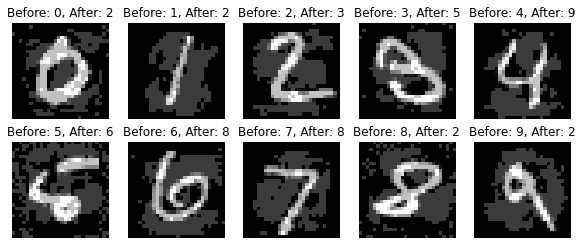

FGSM adversial examples: 7463


In [34]:
figure = plt.figure(figsize=(10, 4))

columns = 5
rows = 2
ax = []
vals = set()

for c in range(10):
    WRITE = True
    for ind, (a_img, a_p, p) in list(enumerate(adv_images_fgsm)):
        vals.add(p)
        if p == c and WRITE:
            ax.append(figure.add_subplot(rows, columns, c+1) )
            ax[-1].set_title(f'Before: {p}, After: {a_p}')
            ax[-1].axis("off")
            plt.imshow(a_img)
            WRITE = False
        
plt.show()
print('FGSM adversial examples:', len(adv_images_fgsm))

### 1.2.1: Using libraries for attacks (10 Points)
As the field of evasion attacks (in particular for DNN) is very active research field, several libraries have been published that contain attacks. We will work here with the Foolbox (https://github.com/bethgelab/foolbox) library. Please implement two other (recent, advanced) attacks of your choice using this library. 

In [17]:
import foolbox as fb

# Load and prepare model
model = base_model().eval()
fmodel = fb.PyTorchModel(model, bounds=(-1, 1))
epsilons1 = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
epsilons2 = [2.0, 2.1, 2.2, 2.3, 2.4, 2.5, 2.6, 2.7, 2.8, 2.9]

# prepare dataset
images = torch.cat([image.reshape(1, 784) for image, label in data_test_loader]).to(DEVICE)
labels = torch.cat([label for image, label in data_test_loader]).to(DEVICE)

# LinfPGD attack
print('LinfPGD ===')
attack = fb.attacks.LinfPGD()
_, adv_images_linf, is_adv = attack(fmodel, images, labels, epsilons=epsilons1)
is_adv_num = is_adv.to('cpu').numpy()
for i, epsilon in enumerate(epsilons1):
    print(f'Epsilon: {epsilon}, Adversarial Accuracy = {1 - is_adv_num[i].mean(axis=-1):.2f}')
# Take epsilon = 0.3
adv_images_linf = adv_images_linf[3]
is_adv = is_adv[3]

adv_images_linf = [(image, None, label) for image, label, tag in zip(adv_images_linf, labels, is_adv) if tag == True]
print('Adversial examples:', len(adv_images_linf), '\n')


# L2DeepFoolAttack attack
print('L2DeepFoolAttack ===')
attack = fb.attacks.L2DeepFoolAttack()
_, adv_images_l2, is_adv = attack(fmodel, images, labels, epsilons=epsilons1)
is_adv_num = is_adv.to('cpu').numpy()
for i, epsilon in enumerate(epsilons2):
    print(f'Epsilon: {epsilon}, Adversarial Accuracy = {1 - is_adv_num[i].mean(axis=-1):.2f}')
# Take epsilon = 2.9
adv_images_l2 = adv_images_l2[9]
is_adv = is_adv[9]

adv_images_l2 = [(image, None, label) for image, label, tag in zip(adv_images_l2, labels, is_adv) if single_predict(image, DEVICE, model) != label]

print('Adversial examples:', len(adv_images_l2), '\n')

LinfPGD ===
Epsilon: 0.0, Adversarial Accuracy = 0.98
Epsilon: 0.1, Adversarial Accuracy = 0.91
Epsilon: 0.2, Adversarial Accuracy = 0.66
Epsilon: 0.3, Adversarial Accuracy = 0.27
Epsilon: 0.4, Adversarial Accuracy = 0.07
Epsilon: 0.5, Adversarial Accuracy = 0.02
Epsilon: 0.6, Adversarial Accuracy = 0.00
Epsilon: 0.7, Adversarial Accuracy = 0.00
Epsilon: 0.8, Adversarial Accuracy = 0.00
Epsilon: 0.9, Adversarial Accuracy = 0.00
Adversial examples: 7283 

L2DeepFoolAttack ===
Epsilon: 2.0, Adversarial Accuracy = 0.98
Epsilon: 2.1, Adversarial Accuracy = 0.98
Epsilon: 2.2, Adversarial Accuracy = 0.98
Epsilon: 2.3, Adversarial Accuracy = 0.98
Epsilon: 2.4, Adversarial Accuracy = 0.97
Epsilon: 2.5, Adversarial Accuracy = 0.97
Epsilon: 2.6, Adversarial Accuracy = 0.96
Epsilon: 2.7, Adversarial Accuracy = 0.96
Epsilon: 2.8, Adversarial Accuracy = 0.95
Epsilon: 2.9, Adversarial Accuracy = 0.95
Adversial examples: 526 



We chose $\epsilon$ = 0.3 for FGSD, $\epsilon$ = 0.3 for LinfPGD and $\epsilon$ = 2.9 for L2DeepFoolAttack because in all cases it still broke the model, but the images were also resemblant of the original instances.

### 1.2.2: Visualizing the results (20 Points)
As before, please plot the new adversarial examples. Compare all crafting techniques (FGSM, 2 methods from Foolbox).


Mean lowest distances from the original column
L0(orig, fgsm): 784.0
L0(orig, l2):   227.0
L0(orig, linf): 420.3
L2(orig, fgsm): 18.021313
L2(orig, l2):   18.15784
L2(orig, linf): 16.172512
Linf(orig, fgsm): 2.0866666
Linf(orig, l2):   1.9926021
Linf(orig, linf): 1.8205884


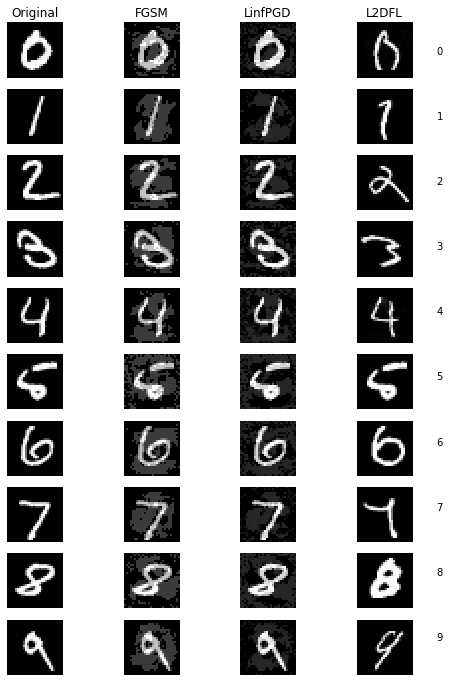

In [33]:
# getters for specific digit exampes
get_num_orig = lambda data, num:  [img.reshape(28, 28) for (img, label) in data if label == num]
get_num_fgsm = lambda data, num:  [img for (img, adv_label, label) in data if label == num]
get_num_linf = lambda data, num:  [img.to('cpu').reshape(28,28) for (img, adv_label, label) in data if label == num]
get_num_l2 = lambda data, num:  [img.to('cpu').reshape(28,28) for (img, adv_label, label) in data if label == num]

# plotting
col_titles = ['Original','FGSM','LinfPGD', 'L2DFL']
fig, axes = plt.subplots(10, 4,figsize=(8,12))
[ax.set_axis_off() for ax in axes.ravel()]
for ax, col in zip(axes[0], col_titles):
    # set up the title for each column
    ax.set_title(col)
  
for digit in range(10):
    plt.text(40, 10-digit*33, str(9-digit))
    
for i in range(10):
  axes[i,0].imshow(get_num_orig(data_test, i)[0])
  axes[i,1].imshow(get_num_fgsm(adv_images_fgsm, i)[0])
  axes[i,2].imshow(get_num_linf(adv_images_linf, i)[0])
  axes[i,3].imshow(get_num_l2(adv_images_l2, i)[0])

# distances
def find_matching(src, data, p):
  min_dist = np.inf
  for img in data:
    if not torch.is_tensor(img):
      img = torch.from_numpy(img)
    loss = torch.norm(src-img, p)
    if loss < min_dist:
      min_dist = loss
  return min_dist.numpy()

print('Mean lowest distances from the original column')
# L0
distances = {'fgsm': [], 'linf': [], 'l2': []}
for i in range(10):
  example_orig = get_num_orig(data_test, 0)[i]
  distances['fgsm'].append(find_matching(example_orig, get_num_fgsm(adv_images_fgsm, i), 0))
  distances['linf'].append(find_matching(example_orig, get_num_linf(adv_images_linf, i), 0))
  distances['l2'].append(find_matching(example_orig, get_num_l2(adv_images_l2, i), 0))
print('L0(orig, fgsm):', np.average(distances['fgsm']))
print('L0(orig, l2):  ', np.average(distances['l2']))
print('L0(orig, linf):', np.average(distances['linf']))

# L2
distances = {'fgsm': [], 'linf': [], 'l2': []}
for i in range(10):
  example_orig = get_num_orig(data_test, 0)[i]
  distances['fgsm'].append(find_matching(example_orig, get_num_fgsm(adv_images_fgsm, i), 2))
  distances['linf'].append(find_matching(example_orig, get_num_linf(adv_images_linf, i), 2))
  distances['l2'].append(find_matching(example_orig, get_num_l2(adv_images_l2, i), 2))
print('L2(orig, fgsm):', np.average(distances['fgsm']))
print('L2(orig, l2):  ', np.average(distances['l2']))
print('L2(orig, linf):', np.average(distances['linf']))

# Linf
distances = {'fgsm': [], 'linf': [], 'l2': []}
for i in range(10):
  example_orig = get_num_orig(data_test, 0)[i]
  distances['fgsm'].append(find_matching(example_orig, get_num_fgsm(adv_images_fgsm, i), np.inf))
  distances['linf'].append(find_matching(example_orig, get_num_linf(adv_images_linf, i), np.inf))
  distances['l2'].append(find_matching(example_orig, get_num_l2(adv_images_l2, i), np.inf))
print('Linf(orig, fgsm):', np.average(distances['fgsm']))
print('Linf(orig, l2):  ', np.average(distances['l2']))
print('Linf(orig, linf):', np.average(distances['linf']))

Besides the first implementation (FGSM) we chose LinfPGD and L2DeepFoolAttack as the two attacks we implemented with the library foolbox. For all attacks we used 0.3 for our epsilon, because the network missclassifies the images while we as humans can still interpret them correctly.

*FGSM*: 
This attack works by using the gradients of the neural network to create an adversarial example, which maximizes the loss. It's done by finiding out how much each pixel in the image contributes to the loss and add a pertubation accordingly. The L0 value shows, that every pixel of the image was modified. The biggest change of all pixels was 2.087 (Linf). Because this attack uses the gradients of the model, whitebox access is needed. The model can still classify some adversarial images correctly but the accuracy only is 0.237.

*LinfPGD*:
This attack is a simple improvement to FGSM. Here the same step as FGSM is applyed multiple times with a small step size. Therefor the pixel values are clipped of the intermediate results after each step to ensure that they are in the epsilon range. Different than BIM, LinfPGD initializes the example to a random point in the ball of interest and does random restarts. The L0 value shows, that about every second pixel of the image was modified. The biggest change of all pixels was 1.821 (Linf). Because this attack uses the gradients of the model as well, whitebox access is needed. The model can still classify some adversarial images correctly but the accuracy only is 0.270.

*L2DeepFoolAttack*:
This last attack is based on an iterative linearization of the classifier to generate minimal perturbations that are sufficient to change classification labels. Like the other attacks, does L2DFA use gradients. So whitebox access is needed here as well. The L0 value shows, that about every 4th pixel of the image was modified. The biggest change of all pixels was 1.993 (Linf). The model can still classify the most adversarial images correctly and scores with an accuracy of 0.950. L0 distance to original shows that more than half the pixels preserved their original values.


Interesting is the difference in L0 and L2 norms. While L0 shows that different models touched vastly different number of pixels, in L2 the disinction is almost none.

# 2. Defending an ML model

So far, we have focused on attacking an ML model. In this section, we want you to defend your model. As before concerning the attack, you can chose an example from the lecture, or experiment with any idea you have.

We do not require the defense to work perfectly - but what we want you to understand is why it works or why it does not work.

### 2.1: Implementing a defense of your choice (25 Points)
As stated before, feel free to implement a defense or mitigation of your choice. Evaluate the defense on adversarial examples. This entails at least the 1,000 examples crafted from FGSM.   
Also, you are encouraged (optional) to defend against the two other attack methods, i.e. you are free to increase this special test set (for example by >30 examples (>10 from your FGSM attack, >10 from both the two other attacks of the library)).

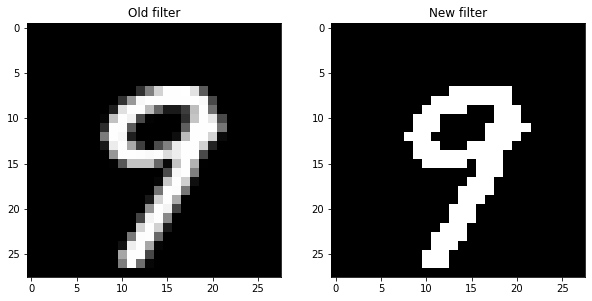

In [35]:
model = base_model()

# custom clipping filter
def clip_img_color(img):
  data = np.array(img)
  avg = np.average(data)*0.5
  return PIL.Image.fromarray(np.array([[0.0 if x <= avg else 1.0 for x in y] for  y in data]))

# transforms
transform_base_smooth = transforms.Compose([
  torchvision.transforms.Lambda(clip_img_color),
  transforms.ToTensor(),
  transforms.Normalize((0.5,), (0.5,)),
])
transform_augmn = transforms.Compose([
  transforms.RandomAffine(
      degrees=35,
      translate=(0.2, 0.2),
      scale=(0.85, 1.15),
  ),
  transforms.ColorJitter(
      brightness=0.5,
      contrast=0.5,
      saturation=0.5,
      hue=0.25,
    ),
])

# data loader and filter wrappers
base_img_prep_new_filter = lambda img: transform_base_smooth(PIL.Image.fromarray(np.array(img).reshape((28,28)))).reshape((1, 784))
base_img_prep_old_filter = lambda img: transform_base(PIL.Image.fromarray(np.array(img).reshape((28,28)))).reshape((1, 784))
bake_data_loader = lambda data: torch.utils.data.DataLoader(data, shuffle=True, batch_size=BATCH_SIZE, num_workers=0)
move_to_cpu = lambda data: [(img.cpu(), adv_label, label) for img, adv_label, label in data]

def comp_no_filter(data):
  adv_images_loader = [(img.reshape(1,784), label) for (img, adv_label, label) in data]
  return evaluate(bake_data_loader(adv_images_loader), loss_fn, DEVICE, model, compute_only=True)

def comp_old_filter(data):
  adv_images_loader = [(base_img_prep_old_filter(img), label) for (img, adv_label, label) in data]
  return evaluate(bake_data_loader(adv_images_loader), loss_fn, DEVICE, model, compute_only=True)

def comp_new_filter(data):
  adv_images_loader = [(base_img_prep_new_filter(img), label) for (img, adv_label, label) in data]
  return evaluate(bake_data_loader(adv_images_loader), loss_fn, DEVICE, model, compute_only=True)


# used for training eval report
eval_no_filter_loader = bake_data_loader([(img.reshape(1, 784), label) for img, label in data_valid])
eval_old_filter_loader = bake_data_loader([(base_img_prep_old_filter(img), label) for (img, label) in data_valid])
eval_new_filter_loader = bake_data_loader([(base_img_prep_new_filter(img), label) for (img, label) in data_valid])

# prepare evaluation data
# no filter
acc_fgsm_no_filter = comp_no_filter(adv_images_fgsm)
acc_linf_no_filter = comp_no_filter(adv_images_linf)
acc_l2_no_filter = comp_no_filter(adv_images_l2) 
acc_eval_no_filter = evaluate(eval_no_filter_loader, loss_fn, DEVICE, model, compute_only=True)
# old filter
acc_fgsm_old_filter = comp_old_filter(adv_images_fgsm)
acc_linf_old_filter = comp_old_filter(move_to_cpu(adv_images_linf))
acc_l2_old_filter = comp_old_filter(move_to_cpu(adv_images_l2))
acc_eval_old_filter = evaluate(eval_old_filter_loader, loss_fn, DEVICE, model, compute_only=True)
# new filter
acc_fgsm_new_filter = comp_new_filter(adv_images_fgsm)
acc_linf_new_filter = comp_new_filter(move_to_cpu(adv_images_linf))
acc_l2_new_filter = comp_new_filter(move_to_cpu(adv_images_l2))
acc_eval_new_filter = evaluate(eval_new_filter_loader, loss_fn, DEVICE, model, compute_only=True)

# used for training eval report
eval_new_filter_loader = bake_data_loader([(base_img_prep_new_filter(img), label) for (img, label) in data_valid])

_, axarr = plt.subplots(1,2) 
axarr[0].set_title('Old filter')
axarr[0].imshow(base_img_prep_old_filter(data_valid[0][0]).reshape(28, 28))
axarr[1].set_title('New filter')
axarr[1].imshow(base_img_prep_new_filter(data_valid[0][0]).reshape(28, 28))

In [36]:
# Hyper parameters
torch.manual_seed(0)
AUGMENTED_FRAC = 0.2
NO_EPOCHS_DEFEND = 70

# prepare training data
data_augmn = list(torchvision.datasets.MNIST('.', train=True, download=True, transform=transform_augmn))
data_augmn = data_augmn[:int(len(data_augmn)*AUGMENTED_FRAC)]
data_train_defend = bake_data_loader([(base_img_prep_new_filter(img), label) for (img, label) in (data_augmn+data_train)])

# train defended model
model = M2().to(DEVICE)
train(model, data_train_defend, eval_new_filter_loader, NO_EPOCHS_DEFEND, 'models_defend')

Epoch 0   ------
Acc: 0.9350 (39/600 bad)
Training Loss: 52418.4166
Saving (0.935000 >= 0.000000)
Epoch 1   ------
Acc: 0.9517 (29/600 bad)
Training Loss: 31182.8895
Saving (0.951667 >= 0.935000)
Epoch 2   ------
Acc: 0.9667 (20/600 bad)
Training Loss: 25758.0715
Saving (0.966667 >= 0.951667)
Epoch 3   ------
Acc: 0.9650 (21/600 bad)
Training Loss: 22870.1870
Epoch 4   ------
Acc: 0.9633 (22/600 bad)
Training Loss: 20852.3762
Epoch 5   ------
Acc: 0.9600 (24/600 bad)
Training Loss: 19215.8936
Epoch 6   ------
Acc: 0.9717 (17/600 bad)
Training Loss: 17999.9210
Saving (0.971667 >= 0.966667)
Epoch 7   ------
Acc: 0.9750 (15/600 bad)
Training Loss: 17186.6117
Saving (0.975000 >= 0.971667)
Epoch 8   ------
Acc: 0.9667 (20/600 bad)
Training Loss: 16027.2867
Epoch 9   ------
Acc: 0.9667 (20/600 bad)
Training Loss: 15470.1023
Epoch 10  ------
Acc: 0.9633 (22/600 bad)
Training Loss: 14624.0529
Epoch 11  ------
Acc: 0.9683 (19/600 bad)
Training Loss: 14241.6359
Epoch 12  ------
Acc: 0.9700 (18/6

In [38]:
print(f'Accuracy on adversarial samples (FGSM)    old model, no filter:  {acc_fgsm_no_filter:2f}')
print(f'Accuracy on adversarial samples (LinfPGD) old model, no filter:  {acc_linf_no_filter:2f}')
print(f'Accuracy on adversarial samples (L2)      old model, no filter:  {acc_l2_no_filter:2f}')
print()
print(f'Accuracy on adversarial samples (FGSM)    old model, old filter: {acc_fgsm_old_filter:2f}')
print(f'Accuracy on adversarial samples (LinfPGD) old model, old filter: {acc_linf_old_filter:2f}')
print(f'Accuracy on adversarial samples (L2)      old model, old filter: {acc_l2_old_filter:2f}')
print(f'Accuracy on evaluation                    old model, old filter: {acc_eval_old_filter:2f}')
print()
print(f'Accuracy on adversarial samples (FGSM)    old model, new filter: {acc_fgsm_new_filter:2f}')
print(f'Accuracy on adversarial samples (LinfPGD) old model, new filter: {acc_linf_new_filter:2f}')
print(f'Accuracy on adversarial samples (L2)      old model, new filter: {acc_l2_new_filter:2f}')
print(f'Accuracy on evaluation                    old model, new filter: {acc_eval_new_filter:2f}')
print()

model = M2()
model.load_state_dict(torch.load("models_defend/epoch_038.pt"))
model.eval()
model.to(DEVICE)

# compute performance on the new data
acc_fgsm_defend = comp_new_filter(adv_images_fgsm)
acc_linf_defend = comp_new_filter(move_to_cpu(adv_images_linf))
acc_l2_defend = comp_new_filter(move_to_cpu(adv_images_l2))
acc_eval_defend = evaluate(eval_new_filter_loader, loss_fn, DEVICE, model, compute_only=True)

print(f'Accuracy on adversarial samples (FGSM)    new model, new filter: {acc_fgsm_defend:2f}')
print(f'Accuracy on adversarial samples (LinfPGD) new model, new filter: {acc_linf_defend:2f}')
print(f'Accuracy on adversarial samples (L2)      new model, new filter: {acc_l2_defend:2f}')
print(f'Accuracy on evaluation                    new model, new filter: {acc_eval_defend:2f}')

Accuracy on adversarial samples (FGSM)    old model, no filter:  0.000000
Accuracy on adversarial samples (LinfPGD) old model, no filter:  0.000000
Accuracy on adversarial samples (L2)      old model, no filter:  0.000000

Accuracy on adversarial samples (FGSM)    old model, old filter: 0.053062
Accuracy on adversarial samples (LinfPGD) old model, old filter: 0.136757
Accuracy on adversarial samples (L2)      old model, old filter: 0.307985
Accuracy on evaluation                    old model, old filter: 0.968333

Accuracy on adversarial samples (FGSM)    old model, new filter: 0.940238
Accuracy on adversarial samples (LinfPGD) old model, new filter: 0.927228
Accuracy on adversarial samples (L2)      old model, new filter: 0.665399
Accuracy on evaluation                    old model, new filter: 0.975000

Accuracy on adversarial samples (FGSM)    new model, new filter: 0.955648
Accuracy on adversarial samples (LinfPGD) new model, new filter: 0.943704
Accuracy on adversarial samples (L2

### 2.2: Conclusions (15 Points)

The defense was split into two parts:

1. Data augmentation, the goal of which was to make the model more robust and improve general performance. The applied operations were random affine transform and color jitter. 20% of the training data were used for data augmentation.
2. More strict input filter, which binarizes the input. This should make the model more robust against small changes in the input, because unless these changes cross the binarization threshold, they are disregarded. The effect of this filter is seen in 2.1.

Any successful adversial attack would then have to flip the specific bit in the image, which would then be immediately noticed by people. This hence prevents any sort of watermark attacks. The model is not obviously safe from FGSM, but it is now much harder to attack, because it is hard to measure how easy people would notice changes to the input (e.g. white pixel in black surrounding is obvious).

Both the library and the FGSM attacked only the model itself, without the filter, which normalizes the input. Putting back the old filter revealed, that some examples could in fact be categorized successfully again. This is most notable with the L2DeepFoolAttack, in which the model regained a 31% of the accuracy. For LinfPGD it was 14% and for our FGSM 5%. Since the FGSM method produced 7463 examples in total, 7090 examples were still adversial even with the old filter, hence fulfilling the >1000 adversial examples requirements. Furthermore, we find this distinction between having the old filter on or off interesting and therefore report such results.

Very interesting is also the fact, that we could use the old model trained with just the normalization filter together with the new filter, which polarizes the pixels and get higher accuracy (97.5%). The accuracy on adversial examples is still > 92% for the old model and the new filter in case of FGSM and LinfPGD.

Training the model on data that went through the new filter and also using the new filter in evaluation provides the best accuracies. It is about 95% for LinfPGD and FGSM and unfortunately just above 66% for L2DeepFoolAttack. This attack produced less results, but the results it produced were harder to defend against. The model overall was still able to regain most of its original performance altogether.